In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rprobertakaggle2/__results__.html
/kaggle/input/rprobertakaggle2/__notebook_source__.ipynb
/kaggle/input/rprobertakaggle2/__notebook__.ipynb
/kaggle/input/rprobertakaggle2/__output__.json
/kaggle/input/rprobertakaggle2/RoBERTa_model_weights.h5
/kaggle/input/rprobertakaggle2/custom.css
/kaggle/input/bertmodelweights/BERTmodel_weights.h5
/kaggle/input/redditresampled/rdResampled.csv


In [1]:
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, BertTokenizer, TFBertForSequenceClassification

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
#Load the tokenizer
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
#Load the model
model_roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=6)
model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
#Define the optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
Accmetric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

In [5]:
#Compile the model
model_roberta.compile(optimizer=optimizer, loss=loss, metrics=[Accmetric])
model_bert.compile(optimizer=optimizer, loss=loss, metrics=[Accmetric])

In [6]:
#Load the saved weights
model_roberta.load_weights('/kaggle/input/rprobertakaggle2/RoBERTa_model_weights.h5')
model_bert.load_weights('/kaggle/input/bertmodelweights/BERTmodel_weights.h5')

In [7]:
import emoji

def preprocess_emojis(texts):
    processed_texts = []
    
    for text in texts:
        processed_text = emoji.demojize(text)
        
        processed_text = processed_text.replace(":", "").replace("_", " ")
        
        processed_texts.append(processed_text)
    
    return processed_texts

In [8]:
def predict_classes(texts, threshold):
    label_mapping_reverse = {0: 'depression', 1: 'Anxiety', 2: 'bipolar', 3: 'BPD', 4: 'schizophrenia', 5: 'autism'}
    predicted_classes = []

    processed_texts = preprocess_emojis(texts)  # Call preprocess_emojis function

    for text in processed_texts:
        encoded_input_roberta = tokenizer_roberta.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_roberta = encoded_input_roberta["input_ids"]
        attention_mask_roberta = encoded_input_roberta["attention_mask"]

        encoded_input_bert = tokenizer_bert.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_bert = encoded_input_bert["input_ids"]
        attention_mask_bert = encoded_input_bert["attention_mask"]

        predictions_roberta = model_roberta.predict([input_ids_roberta, attention_mask_roberta])
        predictions_bert = model_bert.predict([input_ids_bert, attention_mask_bert])

        averaged_probs = (predictions_roberta.logits + predictions_bert.logits) / 2.0
        predicted_class_index = tf.argmax(averaged_probs, axis=1).numpy()[0]
        predicted_class_confidence = tf.nn.softmax(averaged_probs, axis=1).numpy()[0][predicted_class_index]
        print(predicted_class_confidence)

        if predicted_class_confidence > threshold:
            predicted_class = label_mapping_reverse[predicted_class_index]
        else:
            predicted_class = 'None'

        predicted_classes.append(predicted_class)

    return predicted_classes


In [36]:
original_text = ["I'm drowning in a sea of sadness... 😔💧 It feels like I'm suffocating and can't escape these \
overwhelming emotions. 😢💔 Every day is a struggle, and it's hard to see any light at the end of the tunnel. \
😞⛈️ My mind is a tornado of negative thoughts, spinning out of control. 🌪️😣 The weight on my chest is unbearable,\
and it's hard to breathe. 😫😭 #depression #mentalhealth"]

processed_text = preprocess_emojis(original_text)


predicted_classes1 = predict_classes(original_text)
predicted_classes2 = predict_classes(processed_text)


print('original text ',predicted_classes1)
print('emoji mapped text ',predicted_classes2)


1/1 [==============================] - 0s 48ms/step
0.86253166
1/1 [==============================] - 0s 45ms/step
0.86253166
original text  ['depression']
emoji mapped text  ['depression']


In [30]:
processed_text

["I'm drowning in a sea of sadness... pensive facedroplet It feels like I'm suffocating and can't escape these overwhelming emotions. crying facebroken heart Every day is a struggle, and it's hard to see any light at the end of the tunnel. disappointed facecloud with lightning and rain My mind is a tornado of negative thoughts, spinning out of control. tornadopersevering face The weight on my chest is unbearable,and it's hard to breathe. tired faceloudly crying face #depression #mentalhealth"]

In [82]:
predicted_classes1 = predict_classes(original_text,0.60)
print('original text ',predicted_classes1)

1/1 [==============================] - 0s 43ms/step
0.86253166
original text  ['depression']


In [10]:
text=[["I got my diagnosis for free because my mom is transphobic.I'm in my 20 and i love how i played my mom. She was pushing for me to get diagnosis because she read somewhere that girls with autism have problems with experiencing gender (Very common terf talking point) and I'm just confused ect. I know it might be a hard thing for some people to wrap the concept of gender but not for me. I already had a little suspicion i was on a spectrum so i agreed and got diagnosed for free because she paid for everything to prove a point. Turned out I'm just autistic AND trans and my doctor even called my mother to tell her to stop acting like a baby and accept me for who i am. Still a win win for me."],
      ["Does anyone else get angry at themself for not being the person they want to be because of their anxiety? As the title of the post suggests, I get angry at myself for not being able to speak up when I should, say things in meetings when I should (for fear of being judged, looking stupid etc). It's like I have a real version of myself in my head that I want to be and I get annoyed at the anxious, insecure version of myself that I feel I am forced to show to the world because of my anxiety. Does anyone else have this feeling? I beat myself up daily for not feeling able to be there person I want to be particularly in a work context as often I feel I can't speak out in meetings in particular or when someone says something I disagree with. On the occasions where I do speak out I fear it comes across as aggression. It's a daily battle I feel I struggle to win."]
     ,["I'm drowning in a sea of sadness... 😔💧 It feels like I'm suffocating and can't escape these \
overwhelming emotions. 😢💔 Every day is a struggle, and it's hard to see any light at the end of the tunnel. \
😞⛈️ My mind is a tornado of negative thoughts, spinning out of control. 🌪️😣 The weight on my chest is unbearable,\
and it's hard to breathe. 😫😭 #depression #mentalhealth"]]

predicted_classes1 = predict_classes(text,0.60)
print('original text ',predicted_classes1)

1/1 [==============================] - 6s 6s/step
0.99984896
1/1 [==============================] - 3s 3s/step
0.99624157
1/1 [==============================] - 0s 49ms/step
0.828461
original text  ['autism', 'Anxiety', 'depression']


In [11]:
import pandas as pd 
df=pd.read_csv('/kaggle/input/redditresampled/rdResampled.csv')

In [12]:
df=df.drop(['Unnamed: 0'],axis=1)
df.head()

,title_post,Subreddit
0,The end of the road. I've never posted on redd...,depression
1,I can’t write comments. I think I should not c...,depression
2,Attempted hanging myself two years ago. So nea...,depression
3,"25/ f started deliberate self injury. Hi all, ...",depression
4,Venting I guess. I've been crying in my high s...,depression


In [13]:
df.count()

title_post    210000
Subreddit     210000
dtype: int64

In [14]:
X = df['title_post']
y = df['Subreddit']

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
import numpy as np
# Combine X_test and y_test into a single dataset
combined_data = np.column_stack((X_test, y_test))

# Split the combined dataset into training and testing sets
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(combined_data[:, :-1], combined_data[:, -1], test_size=0.2, random_state=42)

In [17]:
print(type(new_X_test))
print(len(new_X_train))
len(new_X_test)

<class 'numpy.ndarray'>
33600


8400

In [18]:
def predictclassesAvg(texts):
    label_mapping_reverse = {0: 'depression', 1: 'Anxiety', 2: 'bipolar', 3: 'BPD', 4: 'schizophrenia', 5: 'autism'}
    predicted_classes = []

    processed_texts = preprocess_emojis(texts)  # Call preprocess_emojis function

    for text in processed_texts:
        encoded_input_roberta = tokenizer_roberta.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_roberta = encoded_input_roberta["input_ids"]
        attention_mask_roberta = encoded_input_roberta["attention_mask"]

        encoded_input_bert = tokenizer_bert.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_bert = encoded_input_bert["input_ids"]
        attention_mask_bert = encoded_input_bert["attention_mask"]

        predictions_roberta = model_roberta.predict([input_ids_roberta, attention_mask_roberta])
        predictions_bert = model_bert.predict([input_ids_bert, attention_mask_bert])

        averaged_probs = (predictions_roberta.logits + predictions_bert.logits) / 2.0
        predicted_class_index = tf.argmax(averaged_probs, axis=1).numpy()[0]
        predicted_class_confidence = tf.nn.softmax(averaged_probs, axis=1).numpy()[0][predicted_class_index]
        print(predicted_class_confidence)
        
        predicted_class = label_mapping_reverse[predicted_class_index]
#         if predicted_class_confidence > threshold:
#             predicted_class = label_mapping_reverse[predicted_class_index]
#         else:
#             predicted_class = 'None'

        predicted_classes.append(predicted_class)

    return predicted_classes


In [19]:
predicted_classes1 = predictclasses(new_X_test[0:3].tolist())
print('original text ',predicted_classes1)

1/1 [==============================] - 0s 74ms/step
0.945456
1/1 [==============================] - 0s 73ms/step
0.99717295
1/1 [==============================] - 0s 79ms/step
0.7875261
original text  ['schizophrenia', 'bipolar', 'Anxiety']


In [60]:
predicted_class_names = predict_classes(new_X_test[0], 0.6)
predicted_class_names

1/1 [==============================] - 0s 46ms/step
0.945456


['schizophrenia']

In [21]:
#because here the function is iterating through each character, not considering the text as a single instance
predicted_class_names = predictclasses(new_X_test[2])
predicted_class_names

1/1 [==============================] - 0s 54ms/step
0.49821362


['depression']

In [67]:
#text considered as single instance
predicted_class_names = predict_classes(new_X_test[2:3])
predicted_class_names

1/1 [==============================] - 0s 54ms/step
0.7875261


['Anxiety']

In [68]:
type(new_X_test)

numpy.ndarray

# making predictions from the avg ensemble model  #

In [23]:
#AVG ENSEMBLE MODEL PREDICTIONS - to compare with indiv transformers
# Perform predictions on the entire test set using the predictclasses function
predicted_class_names = predictclassesAvg(new_X_test)

1/1 [==============================] - 0s 52ms/step
0.945456
1/1 [==============================] - 0s 51ms/step
0.99717295
1/1 [==============================] - 0s 58ms/step
0.7875261
1/1 [==============================] - 0s 55ms/step
0.99990153
1/1 [==============================] - 0s 56ms/step
0.97255266
1/1 [==============================] - 0s 51ms/step
0.37313947
1/1 [==============================] - 0s 52ms/step
0.82927674
1/1 [==============================] - 0s 101ms/step
0.99986863
1/1 [==============================] - 0s 57ms/step
0.9782744
1/1 [==============================] - 0s 60ms/step
0.99704
1/1 [==============================] - 0s 52ms/step
0.9382859
1/1 [==============================] - 0s 61ms/step
0.99878556
1/1 [==============================] - 0s 60ms/step
0.98886395
1/1 [==============================] - 0s 59ms/step
0.98395663
1/1 [==============================] - 0s 55ms/step
0.9954998
1/1 [==============================] - 0s 52ms/step
0.9908236
1

# **Classification Report AVERAGE ENSEMBLE**

In [24]:
# Calculate classification report 
classification_metrics = classification_report(new_y_test, predicted_class_names)
print(classification_metrics)

               precision    recall  f1-score   support

      Anxiety       0.87      0.85      0.86      1389
          BPD       0.79      0.82      0.81      1406
       autism       0.98      1.00      0.99      1415
      bipolar       0.82      0.79      0.80      1396
   depression       0.78      0.81      0.80      1409
schizophrenia       0.92      0.90      0.91      1385

     accuracy                           0.86      8400
    macro avg       0.86      0.86      0.86      8400
 weighted avg       0.86      0.86      0.86      8400



# **Confusion Matrix AVERAGE ENSEMBLE**

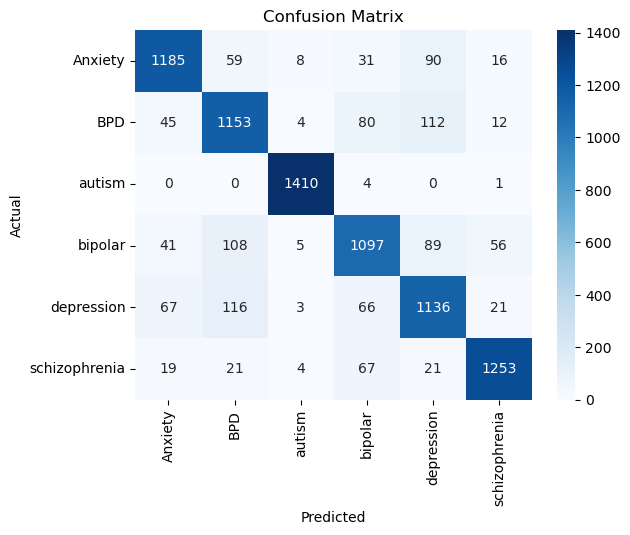

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtain confusion matrix WITH None class
confusion = confusion_matrix(new_y_test, predicted_class_names)

# Convert confusion matrix to a DataFrame for better visualization
labels = ['Anxiety', 'BPD', 'autism', 'bipolar','depression', 'schizophrenia']

confusion_df = pd.DataFrame(confusion, index=labels, columns=labels)

# Create a heatmap of the confusion matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
def predictRaBclasses(texts):
    label_mapping_reverse = {0: 'depression', 1: 'Anxiety', 2: 'bipolar', 3: 'BPD', 4: 'schizophrenia', 5: 'autism'}
    predicted_classes_roberta = []
    predicted_classes_bert = []

    processed_texts = preprocess_emojis(texts)  # Call preprocess_emojis function

    for text in processed_texts:
        encoded_input_roberta = tokenizer_roberta.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_roberta = encoded_input_roberta["input_ids"]
        attention_mask_roberta = encoded_input_roberta["attention_mask"]

        encoded_input_bert = tokenizer_bert.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_bert = encoded_input_bert["input_ids"]
        attention_mask_bert = encoded_input_bert["attention_mask"]

        predictions_roberta = model_roberta.predict([input_ids_roberta, attention_mask_roberta])
        predictions_bert = model_bert.predict([input_ids_bert, attention_mask_bert])

        predicted_class_index_roberta = tf.argmax(predictions_roberta.logits, axis=1).numpy()[0]
        predicted_class_roberta = label_mapping_reverse[predicted_class_index_roberta]
        predicted_classes_roberta.append(predicted_class_roberta)

        predicted_class_index_bert = tf.argmax(predictions_bert.logits, axis=1).numpy()[0]
        predicted_class_bert = label_mapping_reverse[predicted_class_index_bert]
        predicted_classes_bert.append(predicted_class_bert)

    return predicted_classes_roberta, predicted_classes_bert


# making predictions from the roberta and bert models  #

In [ ]:
#getting roberta and bert predictions for the test set - to compare with avg ensemble moodel
predicted_classes_roberta, predicted_classes_bert = predictRaBclasses(new_X_test)

1/1 [==============================] - ETA: 0s

In [29]:
len(predicted_classes_bert)

8400

# **Classification Report & Confusion Matrix RoBERTa**

               precision    recall  f1-score   support

      Anxiety       0.87      0.83      0.85      1389
          BPD       0.83      0.77      0.80      1406
       autism       0.97      0.99      0.98      1415
      bipolar       0.79      0.79      0.79      1396
   depression       0.75      0.83      0.79      1409
schizophrenia       0.91      0.88      0.89      1385

     accuracy                           0.85      8400
    macro avg       0.85      0.85      0.85      8400
 weighted avg       0.85      0.85      0.85      8400



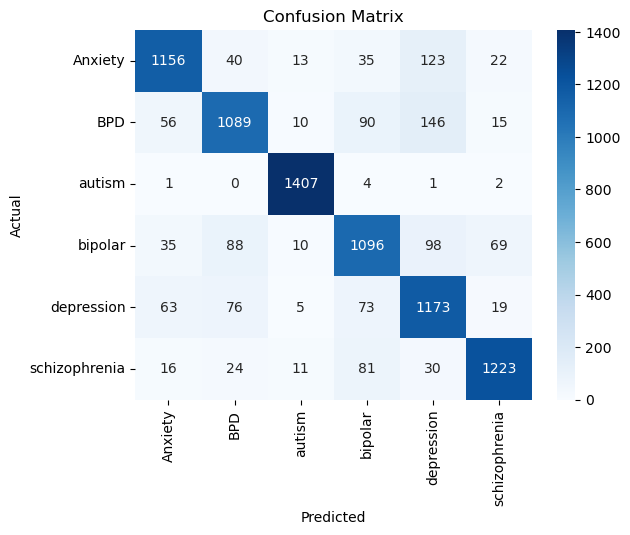

In [33]:
# Calculate classification report 
classification_metrics = classification_report(new_y_test, predicted_classes_roberta)
print(classification_metrics)

# Obtain confusion matrix WITH None class
confusion = confusion_matrix(new_y_test, predicted_classes_roberta)

# Convert confusion matrix to a DataFrame for better visualization
labels = ['Anxiety', 'BPD', 'autism', 'bipolar','depression', 'schizophrenia']

confusion_df = pd.DataFrame(confusion, index=labels, columns=labels)

# Create a heatmap of the confusion matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **Classification Report & Confusion Matrix BERT**

               precision    recall  f1-score   support

      Anxiety       0.84      0.85      0.85      1389
          BPD       0.73      0.84      0.78      1406
       autism       0.98      0.99      0.99      1415
      bipolar       0.83      0.77      0.80      1396
   depression       0.80      0.73      0.76      1409
schizophrenia       0.92      0.90      0.91      1385

     accuracy                           0.85      8400
    macro avg       0.85      0.85      0.85      8400
 weighted avg       0.85      0.85      0.85      8400



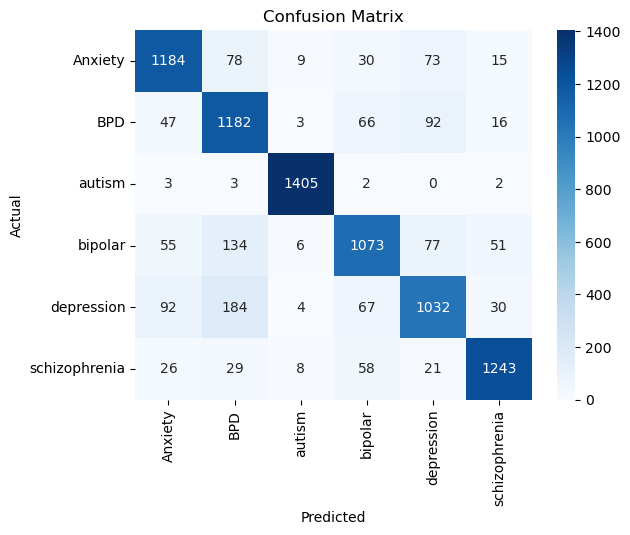

In [34]:
# Calculate classification report 
classification_metrics = classification_report(new_y_test, predicted_classes_bert)
print(classification_metrics)

# Obtain confusion matrix WITH None class
confusion = confusion_matrix(new_y_test, predicted_classes_bert)

# Convert confusion matrix to a DataFrame for better visualization
labels = ['Anxiety', 'BPD', 'autism', 'bipolar','depression', 'schizophrenia']

confusion_df = pd.DataFrame(confusion, index=labels, columns=labels)

# Create a heatmap of the confusion matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [117]:
labels = np.unique(new_y_test)
print(labels)
labels = np.unique(predicted_class_names)
print(labels)

['Anxiety' 'BPD' 'autism' 'bipolar' 'depression' 'schizophrenia']
['Anxiety' 'BPD' 'None' 'autism' 'bipolar' 'depression' 'schizophrenia']


# AVG ENSEMBLE model performs better than individual transformers # 